<a href="https://colab.research.google.com/github/nehapull/rag-exercise/blob/main/neha_pullabhotla_rag_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to our ML project!

This is a quick exercise to help demonstrate your familiarity with RAG systems - one might say that this is a place where you can b**RAG** about your skills! 🤣

In this exercise, you will be asked to build a simple RAG system that answer some provided questions using the dataset provided. We expect this exercise to take 1-3 hours TOPS so use that to temper your approach to building this. We're not looking for reusable or production-level code - we're expressly looking for you to show us that you:

* can explore an unknown dataset
* can use an LLM (in this case, OpenAI's GPT-3) to build a simple RAG system

## The Dataset

You'll find the dataset in `content.csv`. It is a set of content about companies that has been scraped from the web. It contains the following columns:

* `company_id`: a unique identifier for the company (UUID)
* `company_name`: the name of the company
* `url`: the URL from which the content was scraped
* `chunk`: a chunk of the content that was scraped from the `url`
* `chunk_hash`: a hash of the chunk
* `chunk_id`: a unique identifier for the chunk of content
* `chunk_type`: the type of the chunk of content (e.g. `header`, `footer`)


Here's an example:

|company_id|company_name|url|chunk_type|chunk_hash|chunk|chunk_id|
|---|---|---|---|---|---|---|
|4c1fde18-8a40-4ee7-9c3c-19152c7d1ff8|Aboitiz Group|https://aboitiz.com/about-us/the-aboitiz-way/|head|d312f0c688076be80ee2e4af8a51c2f10cbb993a4a8de779cb4aa5545fe1051f|"<head>Aboitiz - The Aboitiz Way</head>"|be36e2f0-cd0b-42eb-b36d-c9403c2428be|

## Step 1: Explore the dataset

Here are some questions that we'd like you to answer about the dataset:

1. How many companies are in the dataset?
2. How many unique URLs are in the dataset?
3. What is the most common chunk type?
4. What is the distribution of chunk types by company?

In [1]:
%pip install pandas
%pip install matplotlib
%pip install openai
%pip install transformers
%pip install sentence-transformers
%pip install spacy-langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.9/266.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

## Step 2: RAGtime!

Now that you're a little more familar with the dataset, let's build a simple RAG system that uses OpenAI to help answer some questions about the dataset. To reiterate, we don't expect you to add anything else to the environment to build this system - for example, you don't need to set up a database or anything like that. You can add any libraries you need to the environment, but we'd like you to use OpenAI for any and all tasks that require a language model (we'll send you a key to use).

That being said, we'd like you to show the specifics of how a RAG implementation works so please avoid using any libraries that provide end-to-end RAG implementations.

Here is the question that we'd like you to answer via your RAG system:

1. What does the company Caravan Health do?

### Step 1: Data Exploration

Import Libraries

In [78]:
import os
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict
import json
from tqdm import tqdm

In [16]:
import nltk
import spacy
nltk.download('punkt')
nltk.download('words')
from nltk.tokenize import sent_tokenize, word_tokenize
from spacy_langdetect import LanguageDetector
from spacy.language import Language

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Data Processing

In [6]:
# Read the data to a pandas dataframe
data = pd.read_csv('/content/drive/MyDrive/exercises/machine-learning/content.csv')
data.head()

,company_id,company_name,url,chunk_type,chunk_hash,chunk,chunk_id
0,4c1fde18-8a40-4ee7-9c3c-19152c7d1ff8,Aboitiz Group,https://aboitiz.com/about-us/the-aboitiz-way/,head,d312f0c688076be80ee2e4af8a51c2f10cbb993a4a8de7...,"<head><meta charset=""utf-8""/><title>Aboitiz | ...",be36e2f0-cd0b-42eb-b36d-c9403c2428be
1,4c1fde18-8a40-4ee7-9c3c-19152c7d1ff8,Aboitiz Group,https://aboitiz.com/about-us/the-aboitiz-way/,header,2c5534296a5e671efb47ccd627d797ec4dbe53dd393c98...,"<header class=""scroll_header_top_area stick sc...",bfba99bd-49d1-43b1-9728-5c04edd151a4
2,4c1fde18-8a40-4ee7-9c3c-19152c7d1ff8,Aboitiz Group,https://aboitiz.com/about-us/the-aboitiz-way/,footer,0bb3d3e6ca11963bcaeeacb07c26a781bc290c878cba57...,"<footer><ul><li><a href=""https://aboitiz.com/""...",7cc48405-f7ef-45a8-99f2-9f900e930e3d
3,4c1fde18-8a40-4ee7-9c3c-19152c7d1ff8,Aboitiz Group,https://aboitiz.com/about-us/the-aboitiz-way/,main,19800e7fa254fdaa8ce593a66961c1ba92b0bd3245c3d9...,"<body class=""page-template page-template-child...",319ac94f-2547-4d9e-b353-cd7997d44ec6
4,47a9fbaa-0c12-442e-b030-78d3ee7b15d3,Bespoke,https://www.be-spoke.io/privacy-policy,head,3f28494cceaeb2ab4060b91d19046b3760de41021fa0fb...,"<head><meta charset=""utf-8""/><title>プライバシーポリシー...",37080a59-9d5c-465d-9d59-807ef3cfb435


In [7]:
data.describe()

,company_id,company_name,url,chunk_type,chunk_hash,chunk,chunk_id
count,2128,2128,2128,2128,2128,2128,2128
unique,75,75,530,4,1337,1337,2128
top,1d793954-ad6e-4d64-84d6-965b6d7e6e28,Abelini,https://www.westdermatology.com/,header,fa4f773a4d750c100202d812c3b71cf999a8472b14cebc...,"<footer class=""custom_footer"">Action24 Unit C1...",20920735-552b-4cd4-b4f1-ca48b8b88c35
freq,55,55,10,549,11,11,1


1. How many companies are in the dataset?

In [8]:
# How many companies are in the dataset?
data['company_id'].nunique()

75

2. How many unique URLs are in the dataset?

In [9]:
# How many unique URLs are in the dataset?
data['url'].nunique()

530

3. What is the most common chunk type?

In [10]:
# What is the most common chunk type?
data['chunk_type'].describe().top

'header'

4. What is the distribution of chunk types by company?

In [89]:
# What is the distribution of chunk types by company?
# chunk_type_grouped = data['chunk_type'].groupby(data['company_name'])
chunk_type_grouped = data.groupby('company_name')['chunk_type'].value_counts()
# convert to a dataframe
chunk_type_grouped = chunk_type_grouped.unstack(fill_value=0)
chunk_type_grouped

chunk_type,footer,head,header,main
company_name,,,,
24Hrbookkeeper,0,1,0,1
365games.net,10,11,11,11
4wheeltravels.com,0,2,0,2
579twu.org,0,11,0,11
66corporation.com,4,4,4,4
...,...,...,...,...
bhatiagraphica.com,5,5,7,0
bijvoorbeeldzo,11,11,11,11
bikesandmunchies.com,9,9,9,0


<Figure size 1000x200 with 0 Axes>

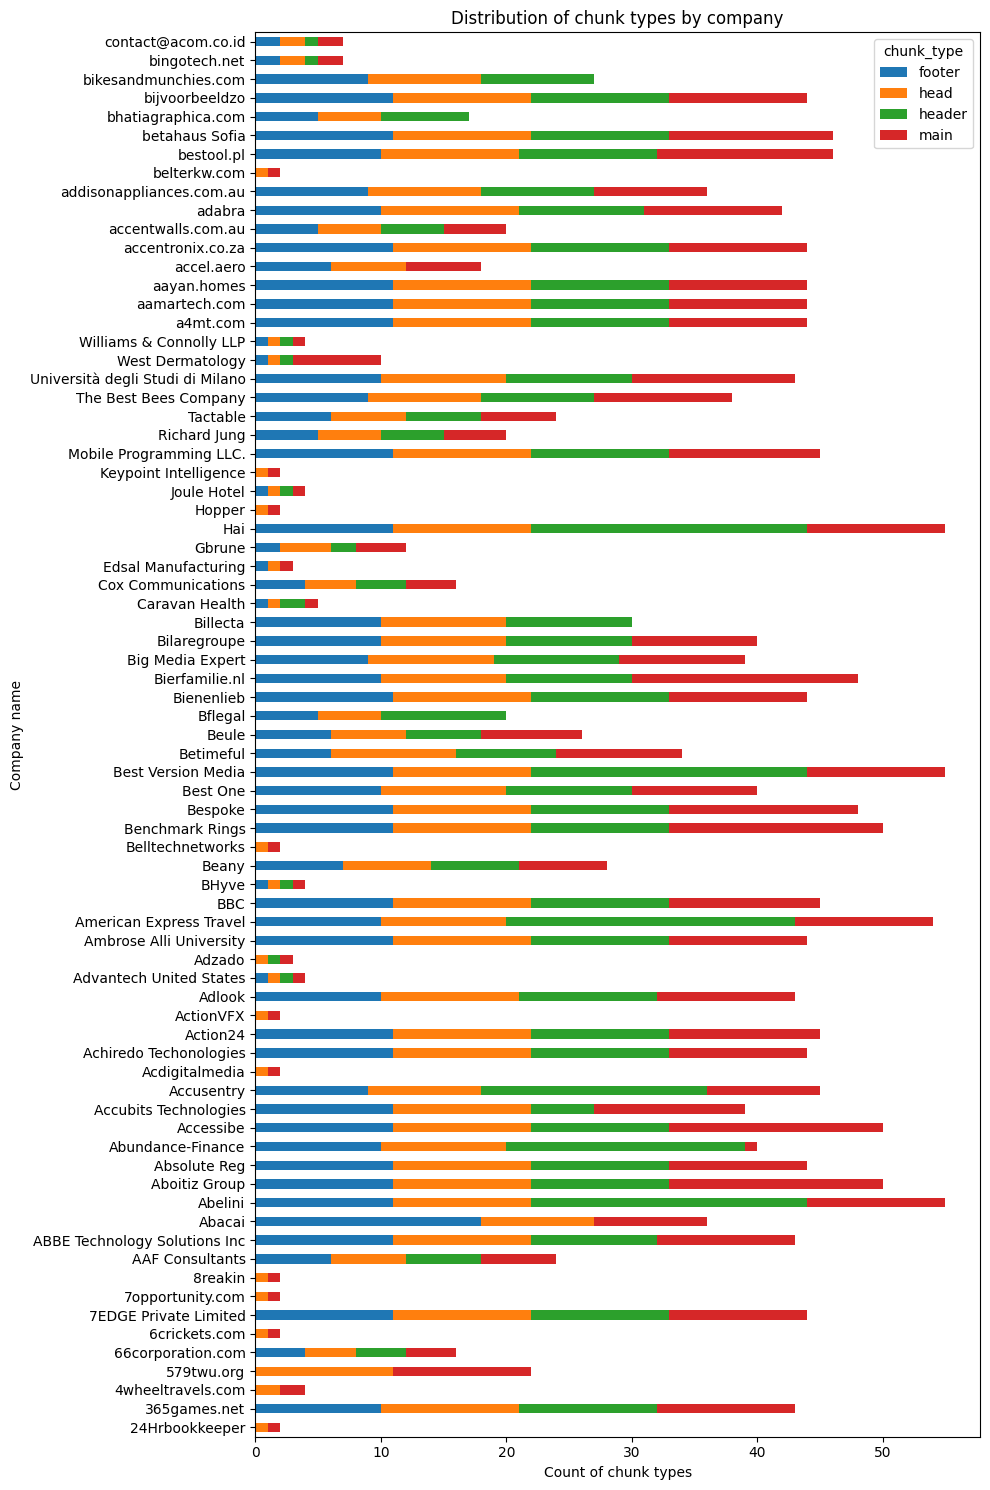

In [88]:
# Visualize the above

plt.figure(figsize=(10, len(chunk_type_grouped.columns) * 0.5))
chunk_type_grouped.plot(kind='barh', stacked=True, figsize=(10, 15))
plt.title("Distribution of chunk types by company")
plt.xlabel('Count of chunk types')
plt.ylabel("Company name")
plt.tight_layout()
plt.show()

Some initial thoughts I had about the data and how to chunk the data:

In [13]:
### THINGS TO CONSIDER:
# How should text containing foreign language be handled?
# What is the chunking strategy? - Need to also find out the average length of a chunk in the data
# I considered combining all data related to 1 company together (treat it as 1 document) and then chunk
# But then I'll have to be careful about how I chunk - not lose information/context
# So probably better to treat each scraped chunk as separate - BUT - some of the chunks are HUGE so need to re-chunk anyway!

#### Additional Data Analysis

Find the avergae chunk length


*   This would help understand if chunking is necessary in the first place -- The context window of an embedding model is 512 tokens. If the chunks are longer than 512 tokens, they would need to be further broken down into smaller chunks.



The average length of a chunk is: 4320.78


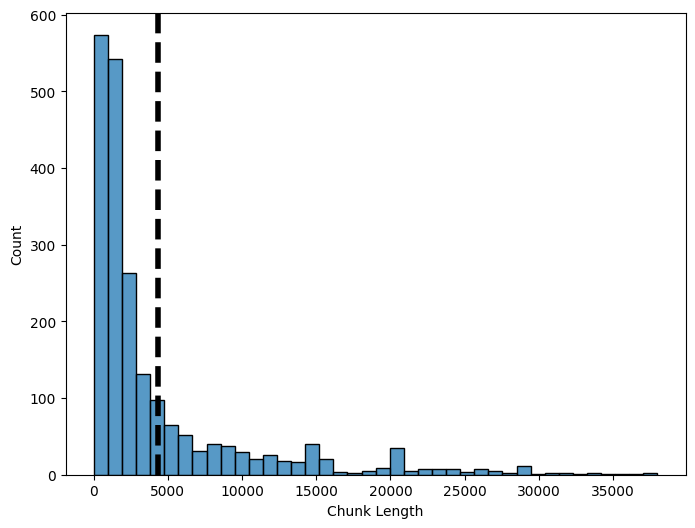

In [80]:
# data['chunk'][3]
# Get the lengths of the chunks to determine chunk overlap parameter
data['chunk_length'] = data['chunk'].map(lambda x: len(x))
chunk_length = data.chunk_length.values
mean_length = np.mean(chunk_length)
print ("The average length of a chunk is: %.2f" % (mean_length))

fig = plt.figure(figsize=(8,6))
ax = fig.gca()
# Look at the distribution of the data
ax = sns.histplot(x=chunk_length, bins=40, ax=ax, kde=False)
ax.axvline(mean_length, lw=4, ls='dashed', color='black')
ax.set(xlabel='Chunk Length')
plt.show()

Takeaway: Since the average length of a chunk is ~ 4320 tokens, we definitely need to chunk the data further!

Here we just want to initially see on an average how many chunks were scraped per company


*   This might be helpful later on when we need to determine how many top matching documents we want our retriever to retrieve.



In [87]:
# Get the average number of chunks per company (for top-k)
chunk_type_grouped.sum(axis=1).mean()

28.373333333333335

Clean the HTML tags by using Python's HTML Parser


*   I chose this since I can customize the parser to parse the HTML and store the text parts of it.



In [17]:
# Source inspired from: https://docs.python.org/3/library/html.parser.html#example-html-parser-application

from html.parser import HTMLParser

# Override the `handle_data` function of the HTMLParser class
# We modified the function to store the text data in a python list
class MyHTMLParser(HTMLParser):
    def __init__(self):
        super(MyHTMLParser, self).__init__()
        self.data_extracted = []

    def handle_data(self, data):
#         print("Encountered some data  :", data)
        self.data_extracted.append(data)

During the data exploration, I noticed that some text is not in English. To account for such text in the given time constraint, I tried 2 approaches:

1.   Use NLTK library and check if each token in the data is a part of NLTK's large corpus of English words.
2.  Use SpaCy language detector to ensure that the text is in English.  





NLTK approach:

In [19]:
def clean_multilingual_data_nltk(sent):
  # Consider the set of all English words
  words = set(nltk.corpus.words.words())
  # Tokenize the text and check if each word is an English word
  return " ".join(token for token in nltk.wordpunct_tokenize(sent) if token.lower() in words or not token.isalpha())

Test it out:

In [90]:
print("Original: ", data['chunk'][0])

Original:  <head><meta charset="utf-8"/><title>Aboitiz | The Aboitiz Way</title><meta content="width=device-width,initial-scale=1,user-scalable=no" name="viewport"/><meta content="max-image-preview:large" name="robots"/></head>


In [91]:
print("Processed for English words with NLTK: ", clean_multilingual_data_nltk(data['chunk'][0]))

Processed for English words with NLTK:  < head >< meta =" - 8 "/>< title > | The Way </ title >< meta content =" width = device - width , initial - scale = 1 , user - scalable = no " name =" "/>< meta content =" - image - preview : large " name =" "/></ head >


Takeaway: As we can see from using the NTLK approach to handling multilingual data -- company names are not considered English "words" and we would lose them. As a result, this approach was dropped and SpaCy's language detector was considered below.

SpaCy approach:

In [22]:
def get_lang_detector(nlp, name):
    return LanguageDetector()

# Add the SpaCY language detector to the pipeline
nlp = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

In [23]:
def clean_multilingual_data_spacy(sent):
  chunk = nlp(sent)
  detect_language = chunk._.language
  if detect_language['language'] == 'en':
    return True
  return False

In [96]:
print("Original: ", data['chunk'][0])
print("Processed for English language detection with SpaCy: ", clean_multilingual_data_spacy(data['chunk'][0]))

Original:  <head><meta charset="utf-8"/><title>Aboitiz | The Aboitiz Way</title><meta content="width=device-width,initial-scale=1,user-scalable=no" name="viewport"/><meta content="max-image-preview:large" name="robots"/></head>
Processed for English language detection with SpaCy:  True


Takeaway: this detects the language correctly, I further validate this later in the notebook after chunking the data

### Step 2: Building RAG system

#### Chunking the dataset

*   After parsing the text from the HTML for each chunk in the data, I combined the text in one chunk (for example, the title and the body) and delimted them by a period ('.').

*   Since the average chunk lengths from the data analysis showed the need for further chunking to ensure that the tokens are within 512 (the max context window for the embedding model), we need to carefully chunk the text to preserve the overall meaning.

Tokenization:
*  I then tokenized the chunks by sentence instead of words using NLTK. The reason that I did sentence-level tokenization instead of word-level tokenization is to preserve the context of a sentence after chunking. Often times, when chunking data, we might accidentally break the text at parts that lose out on the meaning of the text.

*   After sentence tokenization, I found a lot of reptetive sentences in the data, so we filter each chunk to only contain unique set of sentences.


Chunking:
*   My approach here was to append each sentence to a chunk until we reach the max token limit of 512. If a sentence is too long to fit into a chunk, we create a new chunk for that sentence. This works because the average sentence length in this dataset is 28. If the average sentence length was greater than or equal to 512, then this approach would not work. Instead, we would have had to tokenize by words and then append each word to the chunk until we reached the 512 token count.
*   When I chunked the data, I also prefixed each the chunk with "Company name" so that the retrived chunks contain more clarity on which company it is referring to. This also helps retrive the right chunks when a similarity search is computed between the user query that mentions a company name and the chunks that are retrieved.
*   I also keep track of the chunk_id corresponding to each chunk, and also additionally add an index that keeps track of the chunk number in the dataset. This is useful when evaluating the RAG system. For example, the first chunk has "'id': 'bfba99bd-49d1-43b1-9728-5c04edd151a4_0'" where the `_0` at the end of the ID indicates that it is the first chunk in the dataset.

Improvements:


*   If I had more time, I would look at other chunking strategies -- recursive chunking, semantic chunking.






In [99]:
dataset = []
lengths = []
chunk_number = 0

for index, row in tqdm(data.iterrows()):
    # Clean the data extracted and chunk to 512 tokens
    parser = MyHTMLParser()
    parser.feed(row['chunk'])
    chunk_content = ". ".join(parser.data_extracted)
    lengths += ((lambda x: [len(i) for i in x])(parser.data_extracted))

    # Sentence tokenize
    tokenize_chunk = sent_tokenize(chunk_content)
    unique_tokenized_chunks = list(set(tokenize_chunk))
    create_chunk = f'Company name: {row["company_name"]} | '
    for i, sent in enumerate(unique_tokenized_chunks):
        if (len(create_chunk) + len(sent)) < 512:
            create_chunk += sent + " "
            unique_tokenized_chunks.remove(sent)
        else:
            final_chunk = create_chunk.strip()
            dataset.append({"id": f"{row['chunk_id']}_{chunk_number}", "text": final_chunk})
            chunk_number += 1
            create_chunk = f'Company name: {row["company_name"]} | '

2128it [00:08, 261.31it/s]


In [103]:
print("Average sentence length in a chunk is: ", sum(lengths) / len(lengths))

Average sentence length in a chunk is:  37.368197419682375


In [100]:
dataset

[{'id': 'bfba99bd-49d1-43b1-9728-5c04edd151a4_0',
  'text': 'Company name: Aboitiz Group | Europa Awards. technical vocational. One Food Group. hackathon. premyo bonds. expansion. Woofy. AFP. superdupercon. CBD. Mactan-Cebu International Airport. UN SDG. heritage. Aboitiz Construction. #AboitizDataInnovation. Citigroup. LCF. vaccination. GCNP. donation. Bugallon. D&I. vaccines. product launch. partnership. byaheng digiskarte. Scubasurero. #BetterTogether. Solar. Environment. data science. Filter by. National ID. Foressa Mountain Town. ABAC Philippines. PBCWE.'},
 {'id': 'bfba99bd-49d1-43b1-9728-5c04edd151a4_1',
  'text': 'Company name: Aboitiz Group | IAP. wetland. PSA. UBP. mental health. ESG. Unity. PSAC Digital Infra. WGE. disaster preparedness. bonds. rebranding. SOCOTECO II. Type. #GreatTransformation. DSAI. Pangasinan. TVI. LIMA Estates. ECCP. EnerZone. Hedcor. upclose. PETNET. construction. @OneNewAboitiz @TechglomerateInAction @ABAC @ABACPhilippines. SMA. APEC Business Advisory

Here I check if multilingual detection is working

In [27]:
clean_multilingual_data_spacy(dataset[0]['text'])

True

In [108]:
print("Data: ",  dataset[8]['text'])
print("English language detection: ", clean_multilingual_data_spacy(dataset[8]['text']))

Data:  Company name: Bespoke | データポータビリティの権利 - お客様ご自身のデータを当社が移動、コピー、転送するよう要請できる権利。. お客様を記憶し、ウェブサイト使用中にセッションを維持するために本セッションにクッキーを使用しています。. 異議を申し立てる権利 - お客様ご自身のデータ使用に異議を申し立てる権利。. お客様独自のユーザーネームとパスワードでお客様のアカウントへのアクセスを制限する。. ご自身の個人情報やコンピューターやデバイスを、詐欺や個人情報盗難、ウイルスおよびその他の問題から保護する手段について、詳細情報をご覧になりたい場合は、www.getsafeonline.orgをご参照ください。. 当社では、お客様のデータを本ポリシーに則って、必要な期間またはお客様からのデータ削除要請があるまで保有します。. 定義と解釈. 当社ではクッキーの一覧を公開しています。. 自動的に収集されるデータ. 当社は、お客様のデータを様々な方法で収集します。. Eメールアドレスや電話番号などの連絡先. お客様の権利.
English language detection:  False


In [29]:
# https://huggingface.co/sentence-transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

#### Embedding the chunks



*   I decided to embed the chunks using the HuggingFace text embedding model "BAAI/bge-base-en-v1.5" since it seemed to be performing well on the embedding models leaderboard.
*   If I was also considering a multilingual system, I would look for embedding models that can tokenize other languages.



In [30]:
# Start with the embedding model
embed_model_name = "BAAI/bge-base-en-v1.5"
embedding_model = SentenceTransformer(embed_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Define a path to save the vector embeddings

In [34]:
STORE = "/content/drive/MyDrive/exercises/machine-learning/vector_db/"

#### Retriever model

For the retriver, I chose to store the vectors in a simple flat NumPy array, and do a similarity search on this array when retrieving the top simiar chunks.
Reasons:


*   Since the dataset is small, this works pretty efficiently and is a simple approach to quickly storing the computed vectors.
*   However, if the dataset size increases and in a production setting, this can quickly become inefficient and we would rather use a vector databases such as MongoDB Atlas that provide fast retriveal with additional features such as semantic caching. The semantic caching allows vectors that were already retrieved from a previous user query to be stored in a cache, so that when the user asks a similar question again, we do not need to do a similarity search over all the chunks again -- we just check our semantic cache first.

Similarity search:


*   I used a simple cosine similarity since the dataset is small and due to time constraints.
*   To improve the system, I would use a more advanced similarity search such as FAISS with HSNW that provides more accurate and optimized similarity search results.
*  I would also consider implementing a Hybrid Search for production-level systems, where we do a combination of keyword search and semantic search.

Top-k:
*   I initially used a k = 5, but I observed that the last two chunks retrieved are often not related to the company that the user is asking about. One possible reason for this could be because there are not enough chunks matching that company to retrieve the top 5 similar ones.  
*   Setting k = 3 seemed sufficient to retrieve the relevant context.







In [35]:
class RetrieverModel():
  def __init__(self, dataset):
    self.vectors = []
    self.idx = 0
    # These are used as a mapping from the vector array index to the chunk id
    # and mapping the chunk id to its corresponding chunk entry.
    self.index_to_id = {}
    self.id_to_entry = {}

    if os.path.exists(STORE):
      if os.path.exists(os.path.join(STORE, "vectors.npy")):
        self.vectors = np.load(os.path.join(STORE, "vectors.npy"))
        print("Loaded vectors from existing vector store.")
      if os.path.exists(os.path.join(STORE, "idx2id_meta_data.pkl")):
        with open(os.path.join(STORE, "idx2id_meta_data.pkl"), "rb") as handle:
          self.index_to_id = pickle.load(handle)
          print("Loaded index to ID meta data from pickle file.")
      if os.path.exists(os.path.join(STORE, "idx2id_meta_data.pkl")):
        with open(os.path.join(STORE, "id2entry_meta_data.pkl"), "rb") as handle:
          self.id_to_entry = pickle.load(handle)
          print("Loaded ID to entry meta data from pickle file.")

    # If the vectors were not already computed, we compute them here
    if len(self.vectors) == 0 or len(self.index_to_id.keys()) == 0 or len(self.id_to_entry.keys()) == 0:
      self.store_vectors(dataset)

  def get_text_embeddings(self, text):
    text_embeddings = embedding_model.encode(text)
    # store in numpy array
    return text_embeddings

  def store_vectors(self, dataset):
    self.vectors = []
    print("Computing embeddings...")
    for data in tqdm(dataset):
      # Get the embeddings
      embeddings = self.get_text_embeddings(data['text'])
      self.vectors.append(embeddings)
      self.index_to_id[self.idx] = data['id']
      self.id_to_entry[data['id']] = data
      self.idx += 1
    # combine all the vectors into numpy array
    self.vectors = np.stack(self.vectors)
    print("\nStoring embeddings...")
    if not os.path.exists(STORE):
      os.mkdir(STORE)
    np.save(os.path.join(STORE, "vectors.npy"), self.vectors)
    with open(os.path.join(STORE, "idx2id_meta_data.pkl"), "wb") as handle:
      pickle.dump(self.index_to_id, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(STORE, "id2entry_meta_data.pkl"), "wb") as handle:
      pickle.dump(self.id_to_entry, handle, protocol=pickle.HIGHEST_PROTOCOL)

  def retrieve(self, query, topk=3):
    # embed the query using the same model
    query_embedding = self.get_text_embeddings(query)
    distance_matrix = cosine_similarity(query_embedding.reshape(1, -1), self.vectors)
    # print(distance_matrix)
    distances = distance_matrix[0]
    # print(distances)
    # Order the results from cosine similarity in ascending order and then
    # reverse the array to get the most similar vectors.
    top_k_idx = np.argsort(distances)[::-1]
    top_k_docs = [retriever.id_to_entry[retriever.index_to_id[i]] for i in top_k_idx[:topk]]
    return top_k_docs

Initialize the retriever

In [36]:
retriever = RetrieverModel(dataset)

Computing embeddings...


100%|██████████| 2390/2390 [00:36<00:00, 65.31it/s]


Storing embeddings...


Test the retriever

In [37]:
user_query = "What does the company Caravan Health do?"
top_entries = retriever.retrieve(user_query, topk=3)

In [38]:
top_entries

[{'id': 'b84bb0fa-eb24-4f8e-a72b-c79e93bf7a6e_2382',
  'text': "Company name: Caravan Health | Individuals and Families. Close navigation. Stories of significance. CMS Reporting. Search Jobs. total savings to Medicare. We believe healthcare should meet people where they want to be. attributed Medicare lives. Watch Kurt's story to learn more.. Watch the video. We’re privileged to deliver high-touch clinical support to thousands of people every year, improving their outcomes and experiences.. See their feedback."},
 {'id': 'b84bb0fa-eb24-4f8e-a72b-c79e93bf7a6e_2383',
  'text': 'Company name: Caravan Health | Search. Hospitals and Health Systems. Dedicated population health management. Engaging people wherever they receive care. Payors. In-home Health Evaluations. 100%. Stay up to date with news and insights CVS Accountable Care. Hospitals, Health Systems & Clinicians. Medicare ACO PCP partners.'},
 {'id': 'b84bb0fa-eb24-4f8e-a72b-c79e93bf7a6e_2385',
  'text': "Company name: Caravan Healt

#### Generation

For the generation, we utilized OpenAI `gpt-3.5-turbo` model.
We also use the system prompt recommended in the OpenAI documentation that also allows us to get references to the generation. This allows for more interpretability of the answers generated.

In [39]:
import openai
from openai import OpenAI

In [111]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

In [41]:
# OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

The system prompt from the OpenAI docs along with instructions to cite the appropriate chunk IDs used.

In [47]:
OPENAI_CLIENT = OpenAI(api_key=OPENAI_API_KEY)

# https://platform.openai.com/docs/guides/prompt-engineering/tactic-instruct-the-model-to-answer-with-citations-from-a-reference-text
SYSTEM_PROMPT = """You will be provided with a document delimited by triple quotes and a question.
Your task is to answer the question using only the provided document and to cite the passage(s) of the document used to answer the question.
If the document does not contain the information needed to answer this question then simply write: \"Insufficient information.\"
If an answer to the question is provided, it must be annotated with a citation.
Use the following format to cite relevant passages ({\"citation\": …})."""



*   The `get_relevant_cited_context` function formats the top k entries retrived into triple quotes (since we specify this in the system prompt), and additionally add the passage id as the chunk id from our dataset.
*   Additionally, we check if the user query or the relevant chunks retrieved are in English -- if not, we provide a fallback response.



In [48]:
# Generation
# We pass the context and the system prompt to the model
def generate(client, system_prompt, context):
    print(f"context: {context}")
    response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages= [
            {
              "role": "system",
              "content": system_prompt
            },
            {
              "role": "user",
              "content": context
            }
        ],
        max_tokens=1000,
        temperature=0.0001,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0
    )
    result = response.choices[0].message.content
    return result


def get_relevant_cited_context(relevant_passages):
  doc_ids = [_id for _id, _ in relevant_passages]
  for _, passage in relevant_passages:
    if clean_multilingual_data_spacy(passage) is False:
      return None, None, None
  # Format the context
  cited_context = "\n\n".join(['"""' + _relevant_passage + '"""' + f', Passage: {_idx}' for _idx, _relevant_passage in relevant_passages])
  return doc_ids, cited_context, relevant_passages

def retrieve_and_generate(query, top_k=3):
    fallback = "Sorry, the system currently cannot support languages other than English."
    if clean_multilingual_data_spacy(query) is False:
      return fallback
    retriever = RetrieverModel(dataset)
    top_entries = retriever.retrieve(query, top_k)
    # Get the relevant context for the generation model
    chunk_ids, cited_context, relevant_passages = get_relevant_cited_context([(_entry['id'], _entry['text']) for _entry in top_entries])
    if cited_context is None or relevant_passages is None:
      return fallback
    relevant_chunks = " ".join([relavant_passage for _, relavant_passage in relevant_passages])
    # Generate the relevant chunks
    generated_text = generate(client=OPENAI_CLIENT, system_prompt=SYSTEM_PROMPT, context=cited_context + f"\n\n {query}")

    return generated_text


Test the generation

In [115]:
user_query = "What does the company Caravan Health do?"
generated_text = retrieve_and_generate(user_query)

Loaded vectors from existing vector store.
Loaded index to ID meta data from pickle file.
Loaded ID to entry meta data from pickle file.
context: """Company name: Caravan Health | Individuals and Families. Close navigation. Stories of significance. CMS Reporting. Search Jobs. total savings to Medicare. We believe healthcare should meet people where they want to be. attributed Medicare lives. Watch Kurt's story to learn more.. Watch the video. We’re privileged to deliver high-touch clinical support to thousands of people every year, improving their outcomes and experiences.. See their feedback.""", Passage: b84bb0fa-eb24-4f8e-a72b-c79e93bf7a6e_2382

"""Company name: Caravan Health | Search. Hospitals and Health Systems. Dedicated population health management. Engaging people wherever they receive care. Payors. In-home Health Evaluations. 100%. Stay up to date with news and insights CVS Accountable Care. Hospitals, Health Systems & Clinicians. Medicare ACO PCP partners.""", Passage: b84b

In [116]:
generated_text

'The company Caravan Health provides high-touch clinical support to thousands of people every year, improving their outcomes and experiences. They also focus on delivering a more connected, intuitive, and effective care experience for the people they serve through their expertise, enablement tools, and network relationships. {"citation": [b84bb0fa-eb24-4f8e-a72b-c79e93bf7a6e_2382, b84bb0fa-eb24-4f8e-a72b-c79e93bf7a6e_2385]}'

As we can see here, the model is able to answer the question, but also provide appropriate citation to reference the relevant chunks it used. We can use this to validate its answers and ensure it is not hallucinating.
It is also interesting to note that although we set k = 3 and retrieved 3 relevant contexts, the model cites only 2 chunks (so it probably only used those chunks to generate the relevant answer).

In [112]:
user_query = "I want to know more about the The Best Bees Company"
generated_text = retrieve_and_generate(user_query)

Loaded vectors from existing vector store.
Loaded index to ID meta data from pickle file.
Loaded ID to entry meta data from pickle file.
context: """Company name: The Best Bees Company | BBC. Why Some Ecologists Worry About Rooftop Honey Bee Programs. Read The Article →. May 9, 2021. June 27, 2022. A Dollop of Sweet Science. April 21, 2023. The New Hive Mind: Bees in office buildings. Local, Green, and Fair Snapshot: Meet The Best Bees Company. August 25, 2021. October 28, 2020. The buzz about beekeeping: Hobby takes hold across Denver metro area and beyond. September 17, 2021. A’s, Bees, and C’s: A hive of experts can teach you the basics of beekeeping. October 1, 2020.""", Passage: 9e3a53c5-5ecb-42cb-89b9-1f3b5f3c070a_1106

"""Company name: The Best Bees Company | If you're on the outskirts of one of these cities, give us a call to see if we service your town: 617-445-2322‬. Styles vary by size.. Do you offer custom labels?. Not as much as you’d think! Our data points include populat

In [114]:
generated_text

'The document provides information about The Best Bees Company, including their services, data tracking methods, bee breeds they work with, and the importance of maintaining honeybees. The company works with Apis mellifera ligustica, a docile breed of Italian honeybees, and tracks data points such as population, honey levels, mite levels, queen status, temperament, treatment records, and overall health. They can be reached at 617-445-2322 to inquire about their services in specific towns. Additionally, they emphasize the need for maintaining honeybees. For more information about The Best Bees Company, one can refer to the provided passages. {"citation": [aa691d25-706a-4803-85ef-c53d04aca0bb_888]}'

This time the model only used one chunk out of 3 as its reference for generating an answer.

### Other things to work on to improve the system:


Although there are a lot of different ways to improve and optimize the RAG system, some of the things I would consider implementing with more time for a more robust and production-level RAG system are:

*   Adding other fallbacks to user queries, especially if there are no relevant chunks to retrieve.
*   Handling the multimodality.
* Decomposing the user queries into subqueries and generating hypothetical answers and using those answers for retrieval -- this provides more analytical and accurate answers.
* Fine-tuning the embedding model on a synthetic dataset generated from our original dataset.
* Faster vector search techniques such as FAISS-HSNW, and chunk optimization.
* Summarizing retrieved chunks.
* Building an evaluation pipeline with emphasis on answer relevancy and retrieving the correct context.



### Quick Gradio demo

In [45]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.7 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl size=5584 sha256=708fbb278f84365f0bb67fbd354a1b9425559bfc6e9953a6091440fa02a55eaa
  Stored in directory: /root/.cache/pip/wheels/bd/65/9a/671fc6dcde07d4418df0c592f8df512b26d7a0029c2a23dd81
Successfully built ffmpy


I additionally created a quick and simple gradio demo for easy-to-use interface for the rag system

In [46]:
import gradio as gr

inputs = gr.Textbox(lines=7, label="Ask a question here:")
outputs = gr.Textbox(label="System response:")

title = "Company Data Assistant"
description = "Ask me anything related to a company in the database."

# Create the interface
gr.Interface(fn=retrieve_and_generate, inputs=inputs, outputs=outputs, title=title, description=description).launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://fdf95a990cd0bc5621.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
